In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.distributions import Categorical
from torch import optim
from torch import nn
from collections import deque
import numpy as np
import random
import warnings 
warnings.simplefilter('ignore')
seed = 6
torch.manual_seed(seed)

# model

In [2]:
class critic(nn.Module):
    ''' 
    input : state
    output : state_value(scalar)
    '''
    def __init__(self, input_dim):
        super(critic, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,1)

    def forward(self,state):
        state = F.relu(self.fc1(state))
        state = F.relu(self.fc2(state))
        
        # Linear output
        return self.fc3(state)

class actor(nn.Module):
    '''
    input : state 
    output : action_probs(vector)
    '''
    def __init__(self, input_dim, output_dim):
        super(actor, self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,output_dim)
    
    def forward(self, state):
        logits = F.relu(self.fc1(state))
        logits = F.relu(self.fc2(logits))
        
        # softmax output
        return F.softmax(self.fc3(logits),dim=1)

# agent

In [3]:
class PPOAgent(object):
    def __init__(self,env,gamma = 0.99,clip = 0.2,lr = 1e-3,K_epoch = 4):
        # common
        self.device = "cuda"
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        
        # Hyperparamters
        self.gamma = gamma
        self.clip = clip
        self.lr = lr
        self.K_epoch = K_epoch
        
        # critic
        self.critic = critic(self.obs_dim).to(self.device)
        self.critic.apply(self._weights_init)
        
        # actor_new
        self.actor_new = actor(self.obs_dim,self.action_dim).to(self.device)
        self.actor_new.apply(self._weights_init)
        
        # actor_old,同步
        self.actor_old = actor(self.obs_dim,self.action_dim).to(self.device)
        self.sync()
        
        # optimizer
        self.critic_optimizer = optim.Adam(self.critic.parameters(),lr=lr)
        self.actor_optimizer = optim.Adam(self.actor_new.parameters(),lr=lr)
        
        # recorder
        self.recorder = {'a_loss':[],
                         'v_loss':[],
                         'e_loss':[],
                         'ratio':[]}
            
    @staticmethod
    def _weights_init(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.1)
    
    def sync(self):
        for old_param, new_param in zip(self.actor_old.parameters(),self.actor_new.parameters()):
            old_param.data.copy_(new_param.data)
    
    def get_action(self,state):
        state = torch.FloatTensor([state]).to(self.device)
        probs = self.actor_new(state) # softmax_probs
        dist = Categorical(probs) # Categorical distribution
        act = dist.sample() # smaple action from this Categorical distribution
        return act.detach().item()
    
    def get_value(self,state):
        state = torch.FloatTensor([state]).to(self.device)
        value = self.critic(state)
        return value.item()
    
    def compute_returns(self,rewards):
        returns = []
        G = 0
        
        for r in rewards[::-1]:
            G = r + self.gamma*G
            returns.insert(0,G)
        
        # normalize
        returns = np.array(returns)
        returns = (returns-returns.mean())/returns.std()
        
        return torch.FloatTensor(returns).to(self.device).view(-1, 1)
    
    def update(self,trajectory):
        
        # get trajectory
        state = torch.FloatTensor([sars[0] for sars in trajectory]).to(self.device)
        action = torch.LongTensor([sars[1] for sars in trajectory]).to(self.device).view(-1, 1)
        rewards = [sars[2] for sars in trajectory]
        next_state = torch.FloatTensor([sars[3] for sars in trajectory]).to(self.device)
        done = torch.FloatTensor([sars[4] for sars in trajectory]).to(self.device).view(-1, 1)
        
        # update K_epoch
        for _ in range(self.K_epoch):    
            # calculate critic loss
            returns = self.compute_returns(rewards)
            values = self.critic(state)
            advantage = returns.detach() - values
            critic_loss = 0.5*(advantage**2).mean()
            
            # calculate actor_loss
            old_p = torch.gather(self.actor_old(state),1,action)
            new_p = torch.gather(self.actor_new(state),1,action)
            ratio = new_p / old_p
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio,1-self.clip,1+self.clip) * advantage.detach()
            actor_loss = -torch.min(surr1,surr2).mean()
            
            # update critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
            # update actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
        
        #同步actor
        self.sync()
    
    def train(self,max_episodes):
        episode_rewards = []
        for episode in range(max_episodes):
            
            # initialize new game
            state = env.reset()
            trajectory = [] # [[s, a, r, s', done], [], ...]
            episode_reward = 0
            done = False
            
            # game loop
            while not done:
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                trajectory.append([state, action, reward, next_state, done])
                episode_reward += reward
                state = next_state
            
            # game over
            print("Episode " + str(episode) + ": " + str(episode_reward))
            episode_rewards.append(episode_reward)
            self.update(trajectory)
        
        return episode_rewards
    
    def play(self,max_episodes):
        
        for episode in range(max_episodes):
            
            # initialize new game
            state = env.reset()
            episode_reward = 0
            done = False
            
            # game loop
            while not done:
                self.env.render()
                action = self.get_action(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                state = next_state
            
            # game over
            print("Episode " + str(episode) + ": " + str(episode_reward))
        
        self.env.close()

In [4]:
import gym

env = gym.make("CartPole-v1")
env.seed(seed)

agent = PPOAgent(env)

history = agent.train(max_episodes=1000)

Episode 0: 30.0
Episode 1: 27.0
Episode 2: 14.0
Episode 3: 32.0
Episode 4: 27.0
Episode 5: 10.0
Episode 6: 13.0
Episode 7: 15.0
Episode 8: 20.0
Episode 9: 9.0
Episode 10: 15.0
Episode 11: 32.0
Episode 12: 28.0
Episode 13: 20.0
Episode 14: 18.0
Episode 15: 24.0
Episode 16: 43.0
Episode 17: 37.0
Episode 18: 30.0
Episode 19: 43.0
Episode 20: 29.0
Episode 21: 21.0
Episode 22: 75.0
Episode 23: 110.0
Episode 24: 53.0
Episode 25: 31.0
Episode 26: 103.0
Episode 27: 9.0
Episode 28: 16.0
Episode 29: 12.0
Episode 30: 13.0
Episode 31: 20.0
Episode 32: 10.0
Episode 33: 10.0
Episode 34: 18.0
Episode 35: 9.0
Episode 36: 19.0
Episode 37: 26.0
Episode 38: 12.0
Episode 39: 15.0
Episode 40: 41.0
Episode 41: 82.0
Episode 42: 122.0
Episode 43: 76.0
Episode 44: 72.0
Episode 45: 33.0
Episode 46: 111.0
Episode 47: 45.0
Episode 48: 76.0
Episode 49: 56.0
Episode 50: 19.0
Episode 51: 64.0
Episode 52: 184.0
Episode 53: 127.0
Episode 54: 164.0
Episode 55: 93.0
Episode 56: 114.0
Episode 57: 117.0
Episode 58: 115.0


Episode 440: 428.0
Episode 441: 500.0
Episode 442: 500.0
Episode 443: 485.0
Episode 444: 500.0
Episode 445: 500.0
Episode 446: 500.0
Episode 447: 500.0
Episode 448: 500.0
Episode 449: 500.0
Episode 450: 500.0
Episode 451: 500.0
Episode 452: 500.0
Episode 453: 500.0
Episode 454: 500.0
Episode 455: 500.0
Episode 456: 500.0
Episode 457: 500.0
Episode 458: 500.0
Episode 459: 500.0
Episode 460: 500.0
Episode 461: 500.0
Episode 462: 500.0
Episode 463: 500.0
Episode 464: 500.0
Episode 465: 500.0
Episode 466: 500.0
Episode 467: 500.0
Episode 468: 500.0
Episode 469: 500.0
Episode 470: 500.0
Episode 471: 500.0
Episode 472: 500.0
Episode 473: 500.0
Episode 474: 500.0
Episode 475: 500.0
Episode 476: 500.0
Episode 477: 500.0
Episode 478: 500.0
Episode 479: 500.0
Episode 480: 500.0
Episode 481: 500.0
Episode 482: 500.0
Episode 483: 500.0
Episode 484: 500.0
Episode 485: 500.0
Episode 486: 500.0
Episode 487: 500.0
Episode 488: 500.0
Episode 489: 500.0
Episode 490: 500.0
Episode 491: 500.0
Episode 492:

Episode 873: 500.0
Episode 874: 500.0
Episode 875: 500.0
Episode 876: 500.0
Episode 877: 500.0
Episode 878: 500.0
Episode 879: 500.0
Episode 880: 500.0
Episode 881: 500.0
Episode 882: 500.0
Episode 883: 500.0
Episode 884: 500.0
Episode 885: 500.0
Episode 886: 500.0
Episode 887: 500.0
Episode 888: 500.0
Episode 889: 500.0
Episode 890: 500.0
Episode 891: 500.0
Episode 892: 500.0
Episode 893: 500.0
Episode 894: 500.0
Episode 895: 500.0
Episode 896: 500.0
Episode 897: 500.0
Episode 898: 500.0
Episode 899: 500.0
Episode 900: 500.0
Episode 901: 500.0
Episode 902: 500.0
Episode 903: 500.0
Episode 904: 500.0
Episode 905: 500.0
Episode 906: 500.0
Episode 907: 500.0
Episode 908: 500.0
Episode 909: 500.0
Episode 910: 500.0
Episode 911: 500.0
Episode 912: 500.0
Episode 913: 500.0
Episode 914: 500.0
Episode 915: 500.0
Episode 916: 500.0
Episode 917: 500.0
Episode 918: 500.0
Episode 919: 500.0
Episode 920: 500.0
Episode 921: 500.0
Episode 922: 500.0
Episode 923: 500.0
Episode 924: 500.0
Episode 925:

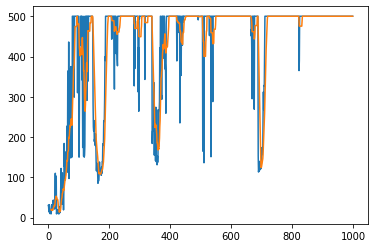

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history)
plt.plot(pd.Series(history).rolling(10).mean())

In [6]:
agent.play(max_episodes=10)

Episode 0: 500.0
Episode 1: 500.0
Episode 2: 500.0
Episode 3: 500.0
Episode 4: 500.0
Episode 5: 500.0
Episode 6: 500.0
Episode 7: 500.0
Episode 8: 500.0
Episode 9: 500.0
